In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['trains1', 'iwildcam-2019-fgvc6', 'reshape32x32']


In [2]:
######WITHOUT RESHAPE 32X32

In [3]:
train= pd.read_csv("../input/iwildcam-2019-fgvc6/train.csv")
test= pd.read_csv("../input/iwildcam-2019-fgvc6/test.csv")
sample_submission= pd.read_csv("../input/iwildcam-2019-fgvc6/sample_submission.csv")
#print("train.shape:", train.shape)
print("test.shape:", test.shape)
print("sample_submmission.shape:", sample_submission.shape)

#train_images = '../input/train_images/*'
#test_images = '../input/test_images/*'

test.shape: (153730, 10)
sample_submmission.shape: (153730, 2)


In [4]:
import cv2
import glob
import matplotlib.pyplot as plt
import tqdm
import tensorflow as tf
from tensorflow.python.framework import ops
import scipy
from scipy import ndimage
import math
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_auc_score
from PIL import Image

In [5]:
# Get ids and labels
train_id = train['file_name']
labels = train['category_id']
test_id = sample_submission['Id']

img = plt.imread('../input/iwildcam-2019-fgvc6/train_images/'+ train['file_name'][0])
img.shape

(747, 1024, 3)

In [6]:
# The TEST data, load data:
x_test_arr = np.load('../input/reshape32x32/X_test.npy')
print('x_test_arr shape:', x_test_arr.shape)
print(x_test_arr.shape[0], 'test samples')

x_test_arr shape: (153730, 32, 32, 3)
153730 test samples


In [7]:
# Convert the TEST images to float and scale it to a range of 0 to 1
x_test = x_test_arr.astype('float32')
x_test /= 255.

print("x_test.shape:",x_test.shape)

x_test.shape: (153730, 32, 32, 3)


In [8]:
x_trains1 = np.load('../input/trains1/x_trains1.npy')
y_trains1 = np.load('../input/trains1/y_trains1.npy')
print("x_trains1.shape:",x_trains1.shape)
print("y_trains1.shape:",y_trains1.shape)

x_trains1.shape: (96167, 32, 32, 3)
y_trains1.shape: (96167, 23)


In [9]:
# split between train_set and dev_set 
x_train, x_dev, y_train, y_dev = train_test_split(x_trains1, y_trains1, test_size = 0.050, random_state = 32)

print("x_train.shape:",x_train.shape)
print("y_train.shape:",y_train.shape)
print("x_dev.shape:",x_dev.shape)
print("y_dev.shape:",y_dev.shape)

print( "GENERATE Testsets: ")
print( "----------------- ")

# split de test_set in several test_sets
x_testa, x_testb = train_test_split(x_test, test_size = 0.5)
x_test1, x_test2 = train_test_split(x_testa, test_size = 0.5)
x_test3, x_test4 = train_test_split(x_testb, test_size = 0.5)

print("x_test1.shape:",x_test1.shape)
print("x_test2.shape:",x_test2.shape)
print("x_test3.shape:",x_test3.shape)
print("x_test4.shape:",x_test4.shape)


x_train.shape: (91358, 32, 32, 3)
y_train.shape: (91358, 23)
x_dev.shape: (4809, 32, 32, 3)
y_dev.shape: (4809, 23)
GENERATE Testsets: 
----------------- 
x_test1.shape: (38432, 32, 32, 3)
x_test2.shape: (38433, 32, 32, 3)
x_test3.shape: (38432, 32, 32, 3)
x_test4.shape: (38433, 32, 32, 3)


In [10]:
### CCN with Tensorflow

In [11]:
def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """
    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0)) 
    Y = tf.placeholder(tf.float32, shape=(None, n_y))
    
    return X, Y

def initialize_parameters():
    """
    Initializes weight parameters to build a neural network with tensorflow. The shapes are:
                        W : [fc, fc, Nc_1, Nc]
    Returns:
    parameters -- a dictionary of tensors containing W1 W2
    """
    
    tf.set_random_seed(1)                              # so that your "random" numbers match ours

    W1 = tf.get_variable("W1", [4, 4, 3, 32], initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", [2, 2, 32, 64], initializer = tf.contrib.layers.xavier_initializer(seed = 0))

    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Returns:
    Z3 -- the output of the last LINEAR unit
    """ 
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X,W1, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize = [1,8,8,1], strides = [1,8,8,1], padding = 'SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1,W2, strides = [1,1,1,1], padding = 'SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize = [1,4,4,1], strides = [1,4,4,1], padding = 'SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 23 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 23,activation_fn=None)
    return Z3

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Returns:
    cost - Tensor of the cost function
    """
    cost = tf.reduce_mean(tf.losses.mean_squared_error(Y, Z3))
    
    return cost

In [12]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples) (m, Hi, Wi, Ci)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples) (m, n_y)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [13]:
def model(X_train, Y_train, X_test, Y_test, X_test_test ,X_test_test1, X_test_test2,X_test_test3,X_test_test4, learning_rate = 0.009,num_epochs = 20, minibatch_size = 64, print_cost = True):
    """
    Implements a three-layer ConvNet in Tensorflow:
    CONV2D -> RELU -> MAXPOOL -> CONV2D -> RELU -> MAXPOOL -> FLATTEN -> FULLYCONNECTED
    
    Arguments:
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    train_accuracy -- real number, accuracy on the train set (X_train)
    test_accuracy -- real number, testing accuracy on the test set (X_test)
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape             
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Inilitialize parameters 
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the optimizer and the cost, the feedict should contain a minibatch for (X,Y).
                _ , temp_cost = sess.run([optimizer,cost], feed_dict ={X:minibatch_X, Y:minibatch_Y})
                 
                minibatch_cost += temp_cost / num_minibatches
                
            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
                                      
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3,1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        
        if X_train.shape[0]>30000:
            train_accuracy = accuracy.eval({X: X_train[:25000], Y: Y_train[:25000]})
            number_for_train_accuracy=25000
        else:
            train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
            number_for_train_accuracy=X_train.shape[0]
        if X_test.shape[0] >25000:
            test_accuracy = accuracy.eval({X: X_test[:25000], Y: Y_test[:25000]})
            number_for_test_accuracy=25000
        else:
            test_accuracy = accuracy.eval({X: X_test, Y: Y_test})     
            number_for_test_accuracy=X_test.shape[0]
            
        print("Train Accuracy:", train_accuracy)
        print("Dev Accuracy:", test_accuracy)
        
            # Calculate Prediction in test_test set
        test_results=[]
        
        prediction1=predict_op.eval({X: X_test_test1})
        test_results.extend(prediction1) 

        prediction2=predict_op.eval({X: X_test_test2})
        test_results.extend(prediction2)
       
        prediction3=predict_op.eval({X: X_test_test3})
        test_results.extend(prediction3) 
       
        prediction4=predict_op.eval({X: X_test_test4})
        test_results.extend(prediction4)
        
        submission = pd.DataFrame({'Id':sample_submission["Id"][:X_test_test.shape[0]],'Predicted':test_results})# test_results.reshape(-1).tolist()})
        submission.to_csv("submission_got_it11.csv", index=False)
        print("Used in training set:", x_train.shape[0],"elements")
        print("Used in validation set:", x_dev.shape[0],"elements")
        print("Used in prediction set:", len(test_results),"elements")
        print("Used for train accuracy:",number_for_train_accuracy, "elements")
        print("Used for dev accuracy:",number_for_test_accuracy, "elements")
        print(submission.head())
        print("Summary of predictions:")
        print(submission.Predicted.value_counts())

        return train_accuracy, test_accuracy, parameters


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use tf.cast instead.
Cost after epoch 0: 0.026543
Cost after epoch 5: 0.021424
Cost after epoch 10: 0.020612
Cost after epoch 15: 0.020231
Cost after epoch 20: 0.019991
Cost after epoch 25: 0.019760
Cost after epoch 30: 0.019578
Cost after epoch 35: 0.019465
Cost after epoch 40: 0.019314
Cost after epoch 45: 0.019230
Cost after epoch 50: 0.019189
Cost after epoch 55: 0.019075
Cost after epoch 60: 0.018999
Cost after epoch 65: 0.018957
Cost after epoch 70: 0.018951
Cost after epoch 75: 0.018831
Cost after epoch 80: 0.018845
Cost after epoch 85: 0.018805
Cost after epoch 90: 0.018743
Cost after epoc

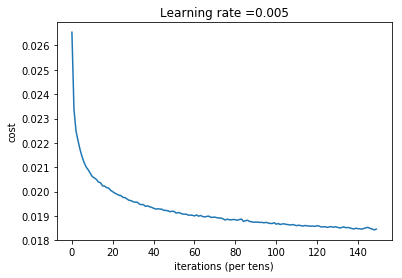

Train Accuracy: 0.70912
Dev Accuracy: 0.6997297
Used in training set: 91358 elements
Used in validation set: 4809 elements
Used in prediction set: 153730 elements
Used for train accuracy: 25000 elements
Used for dev accuracy: 4809 elements
                                     Id  Predicted
0  b005e5b2-2c0b-11e9-bcad-06f10d5896c4         13
1  f2347cfe-2c11-11e9-bcad-06f10d5896c4          0
2  27cf8d26-2c0e-11e9-bcad-06f10d5896c4          8
3  f82f52c7-2c1d-11e9-bcad-06f10d5896c4          0
4  e133f50d-2c1c-11e9-bcad-06f10d5896c4          0
Summary of predictions:
0     98427
19    11108
1      8000
4      7911
8      7674
3      5935
13     5341
11     3652
17     2111
18     1868
16     1703
Name: Predicted, dtype: int64


In [14]:
_, _, parameters = model(x_train, y_train, x_dev, y_dev, x_test, x_test1, x_test2, x_test3, x_test4, learning_rate = 0.0050,num_epochs = 130, minibatch_size = 64, print_cost = True)

In [15]:
print(os.listdir("../working"))

['submission_got_it11.csv', '.ipynb_checkpoints', '__notebook_source__.ipynb']
